optimizer  
gleiche anzahl an bodenklassen innerhalb der reihen  
normalization innerhalb einer Zeitreihe eines Punktes  
shuffle data  

In [1]:
from soil_classification_model_creation import load_LTS_combined
from soil_classification_model_creation import load_gdf
from soil_classification_model_creation import gdf_sjoin_LTS
from soil_classification_model_creation import add_soil_classes
from soil_classification_model_creation import add_radolan
from soil_classification_model_creation import add_soil_moisture
from soil_classification_model_creation import create_pipe

In [2]:
# Paths to Row data from GEE downloads 
filepath_gee_grassland = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/grassland/'
filepath_gee_grassland_DE = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/grassland_DE/'
filepath_gee_bare_soil = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/bare_soil/'
filepath_gee_DE = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/DE/'
filepath_gee_ried = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/ried_soil_samples/'
filepath_gee_ried_10m = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/ried_soil_samples_10m/'
filepath_gee_ried_fullpoints_30m = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/ried_fullpoints_30m_17-19/'

# LUCAS TOPSOIL 2009, 2015, 2015DE datasheets
lts_09 = r"D:\soil_data\LUCAS_TOPSOIL_v1\LUCAS_TOPSOIL_v1.xlsx"
lts_15 = r"D:\soil_data\LUCAS2015_topsoildata_20200323\LUCAS_Topsoil_2015_20200323.csv"
lts_DE = r'D:\soil_data\LUCAS2015_topsoildata_20200323_micro\LUCAS_Topsoil_2015_DE.csv'

#Path to Lucas topsoil databank merged 2009 + 2015
filepath_LTS_grassland = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_grassland.csv'
filepath_LTS_grassland_DE = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_grassland_DE.csv'
filepath_LTS_bare = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_bare.csv'
filepath_LTS_bare_DE = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_bare_DE.csv'
filepath_LTS = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_DE.csv'


In [ ]:
df = load_LTS_combined(
    filepath_09 = lts_09, 
    filepath_15 = lts_15, 
    subset = lts_DE,
    landcover_filter = 'Grassland without tree/shrub cover',)

gdf = load_gdf(
    filepath = filepath_gee_grassland_DE,
    index_column = 'POINT_ID',
    add_na_columns = ['coarse', 'clay', 'silt', 'sand', 'pH_in_H2O', 'pH_in_CaCl2', 'OC', 'CaCO3', 'N', 'P', 'K', 'CEC', 
                      'Notes', 'sample_ID', 'GPS_LAT', 'GPS_LONG', 'Elevation', 'LC1', 'LU1', 'Soil_Stones', 'NUTS_0', 
                      'NUTS_1', 'NUTS_2', 'NUTS_3', 'LC1_Desc', 'LU1_Desc'],
    convert_date = True,
    convert_temperature_to_celvin = ['minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature'],
    create_doy = True,
    dummies_columns = ['platform', 'orbit'],
    columns = ['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING', 
               'day_of_year','mean_2m_air_temperature','maximum_2m_air_temperature','minimum_2m_air_temperature',
               'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 'WaterVapor', 
               'SWIR1', 'SWIR2', 'geometry'],
    dropna = True,
    p_dtypes = True,
    p_head = 3,)

gdf = gdf_sjoin_LTS(
    df = df, 
    gdf = gdf)

gdf = add_soil_classes(
    gdf = gdf,
    filepath_lts_image = r'C:\Users\USER\Desktop\Master_Irrigation\05_Results\classification\overview_lts',)

gdf = add_radolan(gdf = gdf, filepath_radolan = 'D:/jupy_data/precipitation_1km.nc')

gdf = add_soil_moisture(
    gdf = gdf, 
    filepath_ssm_model = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/cnn_models/ssm_30m',
    filepath_df = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_Grassland_DE.csv'
    )

In [4]:
import pandas as pd
gdf = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/DataFrame_Grassland_DE.csv')

C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Initial Rows before preparing data for machine learning: 214171
silt loam          44177
sandy loam         37020
loam               30626
silty clay loam    25758
loamy sand         18406
silty clay         12956
clay loam          11427
sand                7872
clay                5912
sandy clay loam     3482
Name: USDA, dtype: int64
silt loam          20000
clay loam          20000
loam               20000
sandy loam         20000
silty clay loam    20000
sand               20000
clay               20000
loamy sand         20000
silty clay         20000
sandy clay loam    20000
Name: USDA, dtype: int64
Results Rows after preparing data for machine learning: 200000


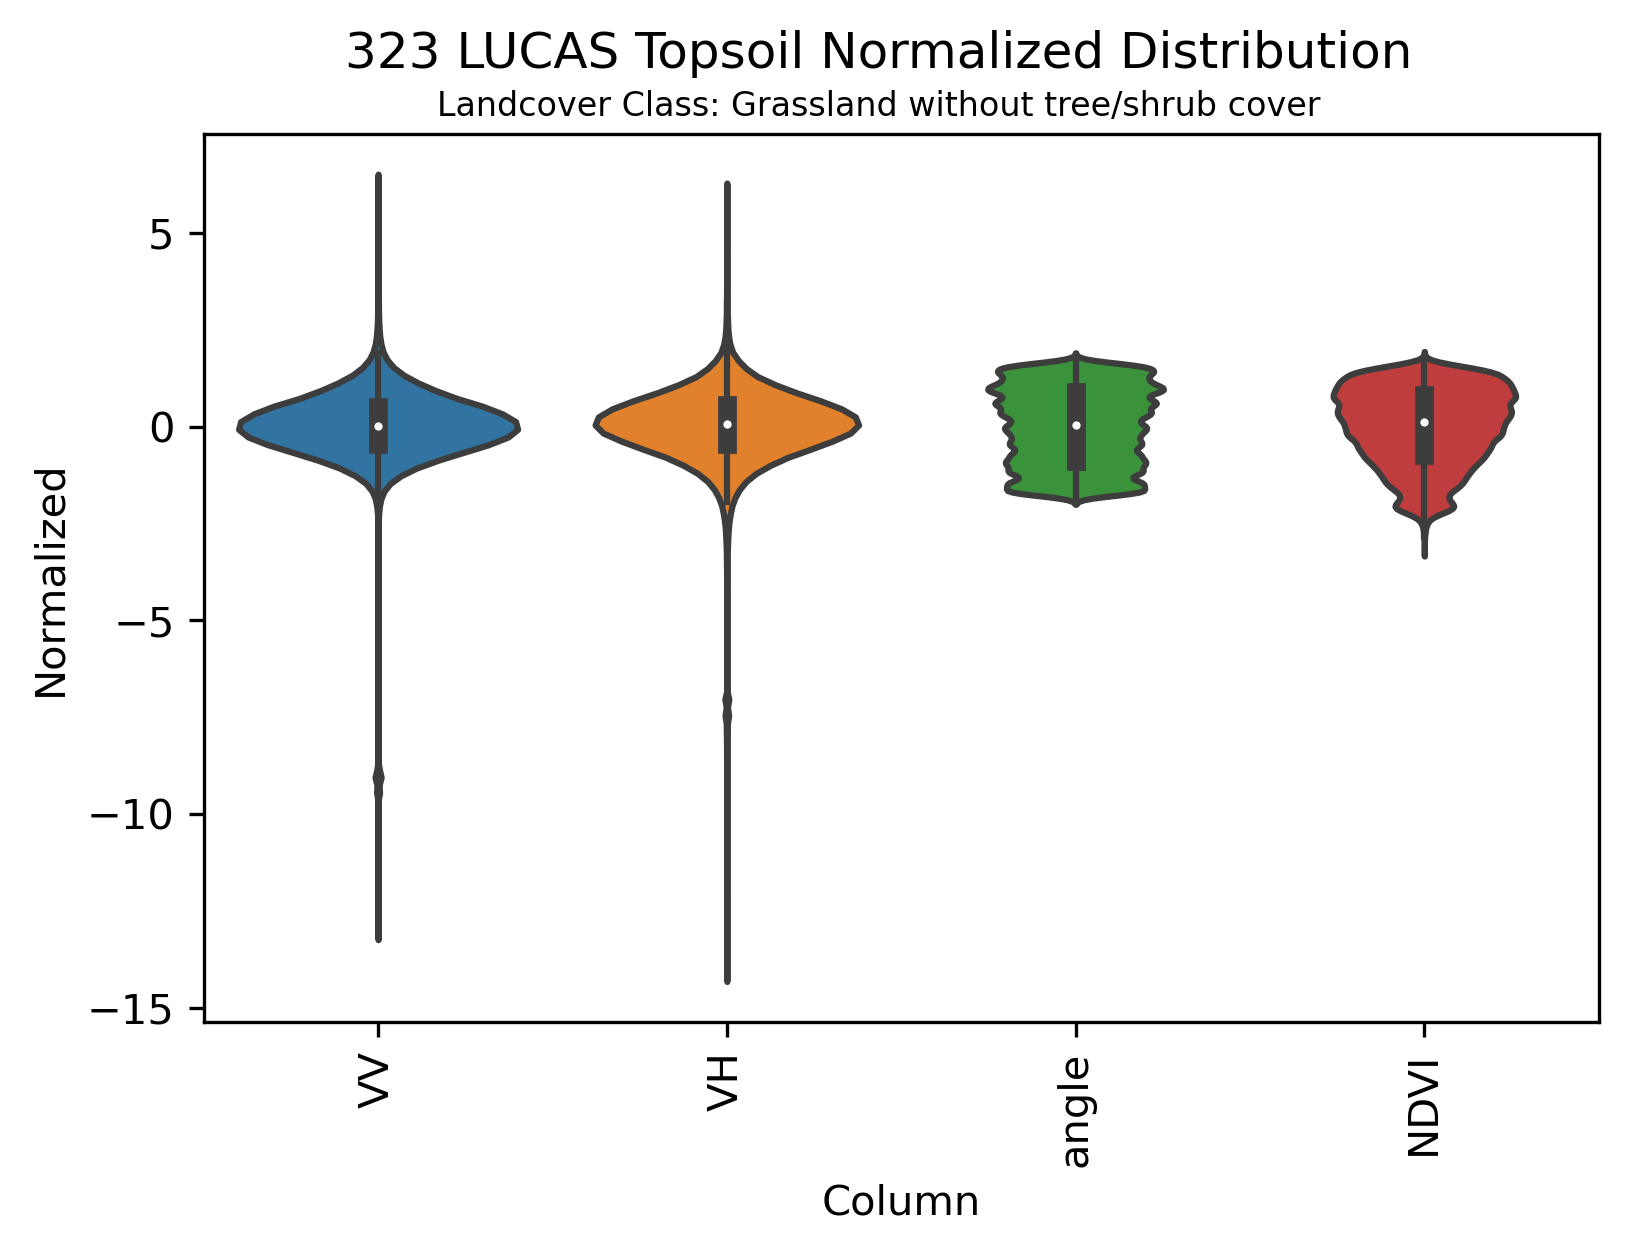

In [5]:
X, y, X_train, X_test, y_train, y_test, labels, target_names, gdf_p = create_pipe(
        gdf = gdf,
        load_from_file = True,
        plot_normalize_to= r'C:\Users\USER\Desktop\Master_Irrigation\05_Results\classification\normalized_distribution_Grassland_DE',
        features_normalization = ['VV', 'VH', 'NDVI','angle', 'day_of_year', 'pp_24h', 'pp_48h', 'pp_72h','mean_2m_air_temperature',
                    'maximum_2m_air_temperature', 'minimum_2m_air_temperature', 'Blue', 'Green', 'Red', 'RedEdge1', 
                    'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 'WaterVapor', 'SWIR1', 'SWIR2', 'ssm'],
        drop_frozen_grounds = False,
        filter_months = None, #[1,2,3,4,5,6,7,8,9,10,11,12]
        shuffle = True,
        apply_bootstrapping = True,
        features_ml = ['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 'orbit_ASCENDING', 
                    'orbit_DESCENDING','minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h',
                    'mean_2m_air_temperature','maximum_2m_air_temperature','minimum_2m_air_temperature', 
                    'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 'WaterVapor', 
                    'SWIR1', 'SWIR2', 'ssm'],
        soil_class = 'USDA',
        test_size = 0.3,
        random_state = 1,
        )


In [6]:
import numpy as np
X_train[np.isnan(X_train)]

array([], dtype=float64)

In [13]:
model = create_model(
    X_train = X_train, 
    X_test = X_test, 
    y_train = y_train, 
    y_test = y_test, 
    model_choose = 'RandomForest', 
    labels = labels, 
    target_names = target_names,
    filepath_confusion_matrix = 'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/models/random_forest/USDA_rf_balanced_20k.png',
    filepath_model_scores = None,
    filepath_model = None) #'C://Users/USER/Desktop/Master_Irrigation/05_Results/classification/models/random_forest/rf_fullrows_nopara_usda.sav'

C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\USER\Anaconda3\envs\dev1\lib\site-packages\numpy\lib\arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


TypeError: '<' not supported between instances of 'int' and 'str'

In [12]:
def create_model(X_train, X_test, y_train, y_test, model_choose, labels, target_names, filepath_model, filepath_confusion_matrix, filepath_model_scores):
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report

    import joblib
    import pandas as pd
    
    def save_confusion_matrix(X_test, y_test, model, labels, display_labels, filepath_confusion_matrix, title_cm):
        cm = ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test), labels = labels, display_labels = display_labels)
        cm.ax_.axis('auto') 
        cm.ax_.set_xticklabels(cm.ax_.get_xticklabels(), rotation=45, ha='right')
        plt.title(f'Confusion Matrix {title_cm}')
        plt.grid(False)
        plt.savefig(filepath_confusion_matrix, dpi=150, bbox_inches='tight')
        return plt.show()  

    def score_model(X_train, X_test, y_train, y_test, model, labels, target_names, filepath_confusion_matrix, filepath_model_scores, train):
        # Instantiate the classification model and visualizer
        if train == 'yes':
            model.fit(X_train, y_train)
            
        # Compute and return F1 (harmonic mean of precision and recall)
        report_dict = classification_report(y_test, model.predict(X_test), 
                                    labels = labels, 
                                    target_names = target_names,
                                    zero_division = 1,
                                    output_dict=True)

        repdf = pd.DataFrame(report_dict).round(2).transpose()
        repdf.insert(loc=0, column='class', value=target_names + ["accuracy", "macro avg", "weighted avg"])
        if filepath_model_scores is not None: repdf.to_csv(filepath_model_scores, index=False)
            
        title_cm = ''
        save_confusion_matrix(X_test, y_test, model, labels, 
                              target_names, 
                              filepath_confusion_matrix, 
                              title_cm,
                             )

        return model
    
    if model_choose == 'RandomForest':
        model = RandomForestClassifier()
    else:
        model = RandomForestClassifier()
    model = score_model(X_train, X_test, y_train, y_test, model, labels, target_names, filepath_confusion_matrix,filepath_model_scores, train='yes')
    
    print(classification_report(y_test, model.predict(X_test), labels = labels, target_names = target_names, zero_division=1))
    
    if filepath_model is not None:
        with open(filepath_model, 'wb') as f:
            joblib.dump(model, f)
    
    return model